## Part 1  Different Model Specs

### A Regression Witout Regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression.

In [1]:
import pandas as pd

hitters_data = pd.read_csv("C:/Users/mehrp/OneDrive/Documents/GitHub/Lab_6_BaseBall_Players/Hitters.csv")

hitters_data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder , PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from plotnine import *

# First things first, let's ditch the rows with no salary info. 
hitters_data_clean = hitters_data.dropna(subset=['Salary'])

# Splitting our data: 'X' for the stuff we know, 'y' for what we're guessing (salary)
X = hitters_data_clean.drop('Salary', axis=1)
y = hitters_data_clean['Salary']

# Gotta figure out which columns are what. Categorical = words; Numeric = numbers.
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# set up our data transformer: Scale the numbers, encode the words.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # This little guy lets other columns just tag along without any change.
)

# Let's build our pipeline: clean up data first, then throw it into a linear regression blender.
linear_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fitting time
linear_reg_pipeline.fit(X, y)

# Grabbing the learned coefficients from our model
coefficients = linear_reg_pipeline.named_steps['regressor'].coef_

# a peek at the top 5 big players (coefficients) in predicting salaries.
important_coefficients = pd.Series(coefficients, index=preprocessor.transformers_[0][2].tolist() + \
                                   preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()) \
                                   .sort_values(key=abs, ascending=False).head(5)
important_coefficients


CRuns     480.747135
CAtBat   -391.038655
Hits      337.830479
AtBat    -291.094556
CRBI      260.689886
dtype: float64

The variables CRuns, CAtBat, Hits, AtBat, and CRBI are identified as significant predictors of salary, with CRuns being the most positively influential and CAtBat showing a surprisingly negative influence.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [3]:
from sklearn.model_selection import cross_val_score
import numpy as np

# 5-fold cross-validation to estimate MSE
mse_scores = -cross_val_score(linear_reg_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

# average MSE
average_mse = np.mean(mse_scores)
average_mse

121136.31031816892

An MSE of around 121,136 suggests that, on average, the model's predictions are off by about $348 (since MSE is in thousands and square-rooted).

## B Ridge Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression.

In [5]:
from sklearn.linear_model import Ridge

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Set up our data transformer: Scale the numbers, encode the words
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ],
    remainder='passthrough'  # Letting other columns tag along without any change
)


ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

2. Use cross-validation to tune the 
 hyperparameter.

In [7]:
from sklearn.linear_model import RidgeCV

# Possible alpha values for Ridge Regression
alphas = [0.01, 0.1, 1, 10, 100]


X_transformed = preprocessor.fit_transform(X)


ridge_cv = RidgeCV(alphas=alphas, cv=5)

# best alpha using cross-validation
best_alpha = ridge_cv.fit(X_transformed, y).alpha_
ridge_pipeline.set_params(ridge__alpha=best_alpha)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('ridge', Ridge(alpha=100.0))])

3. Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

In [8]:
# Fitting the Ridge Regression model
ridge_pipeline.fit(X, y)

# Extracting and displaying the top 5 most influential coefficients
ridge_coefficients = pd.Series(ridge_pipeline.named_steps['ridge'].coef_, 
                               index=preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + \
                               preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()) \
                               .sort_values(key=abs, ascending=False).head(5)
ridge_coefficients

PutOuts    56.881522
Hits       49.612386
CRBI       47.145556
CRuns      45.507606
CHits      44.534276
dtype: float64

The most impactful predictors, according to the Ridge model, are PutOuts, Hits, CRBI, CRuns, and CHits. It's interesting to note the shift in important predictors compared to the linear model.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [9]:
# Estimating the MSE using cross-validation
ridge_mse_scores = -cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
ridge_average_mse = np.mean(ridge_mse_scores)
ridge_average_mse



120716.43558937623

MSE for the Ridge model is approximately 120,716.43. This value is slightly lower than the MSE from the linear regression model, suggesting a slight improvement in prediction accuracy. 

## C Lasso Regression

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

In [10]:
from sklearn.linear_model import Lasso

# Swapping in Lasso this time in our do-it-all pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso())
])

2. Use cross-validation to tune the 
 hyperparameter.

In [20]:
from sklearn.linear_model import LassoCV

# alpha values for Lasso Regression (Wide Range)
lasso_alphas = np.logspace(-3, 2, 100)  # Alphas from 0.001 to 100

# LassoCV to find the best alpha
lasso_cv = LassoCV(alphas=lasso_alphas, cv=5, max_iter=100000)

best_lasso_alpha = lasso_cv.fit(X_transformed, y).alpha_
lasso_pipeline.set_params(lasso__alpha=best_lasso_alpha)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('lasso', Lasso(alpha=2.1544346900318843))])

3. Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.



In [21]:
lasso_pipeline.fit(X, y)

# Which features is Lasso telling us are the real MVPs?
lasso_coefficients = pd.Series(lasso_pipeline.named_steps['lasso'].coef_, 
                               index=preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + \
                               preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()) \
                               .sort_values(key=abs, ascending=False).head(5)
lasso_coefficients

Hits      271.835865
AtBat    -252.325350
CRuns     235.658594
CWalks   -155.822789
CRBI      122.156358
dtype: float64

In the Lasso model, 'Hits' and 'CRuns' significantly increase a player's salary, while 'AtBat' and 'CWalks' show a surprising negative relationship. 'CRBI' also positively influences salary, indicating its importance.

#### I was getinng "ConvergenceWarning" error so I decided to plot and check for outliers. 

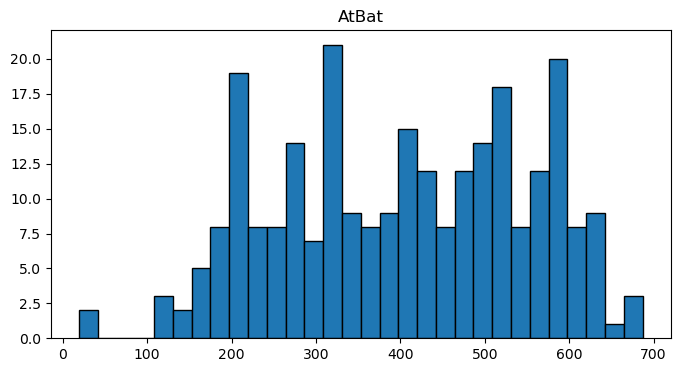

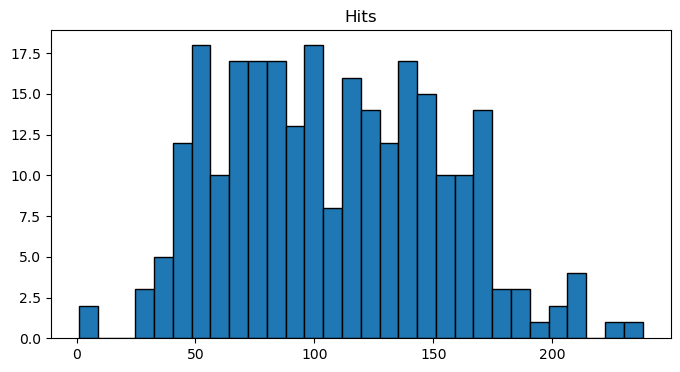

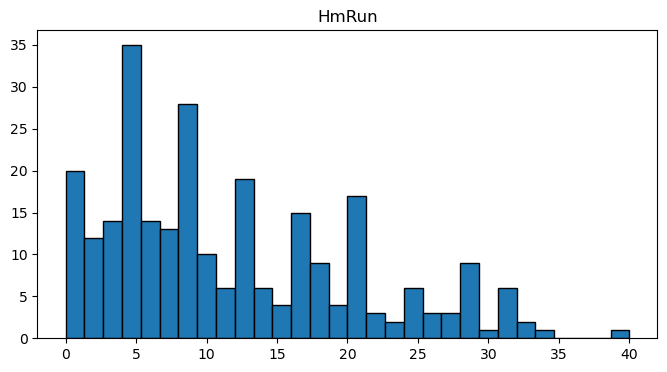

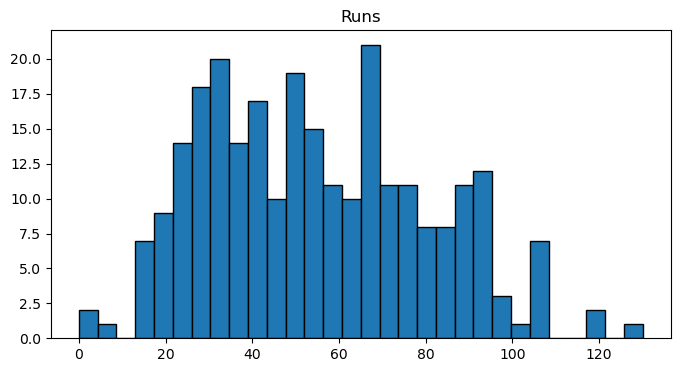

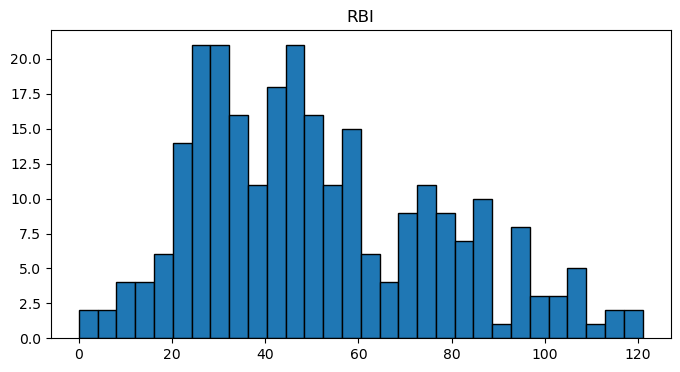

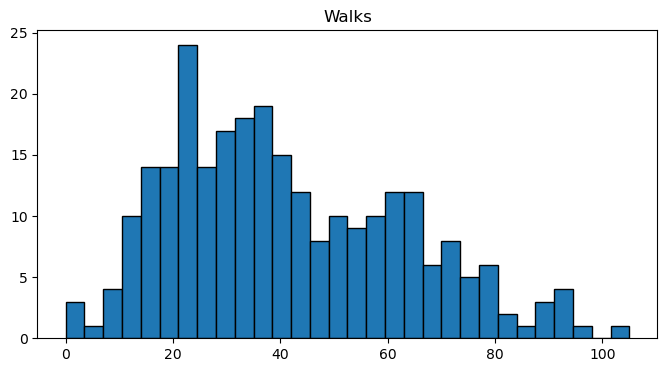

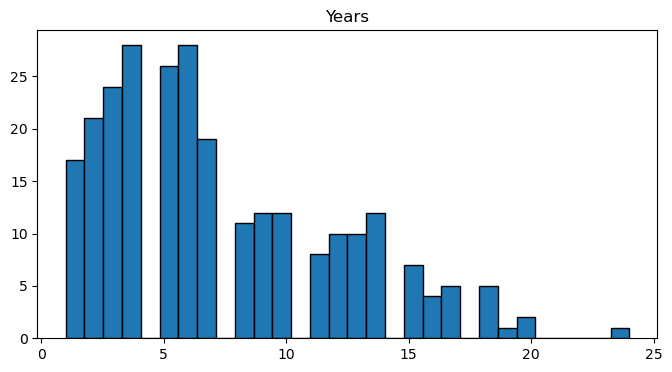

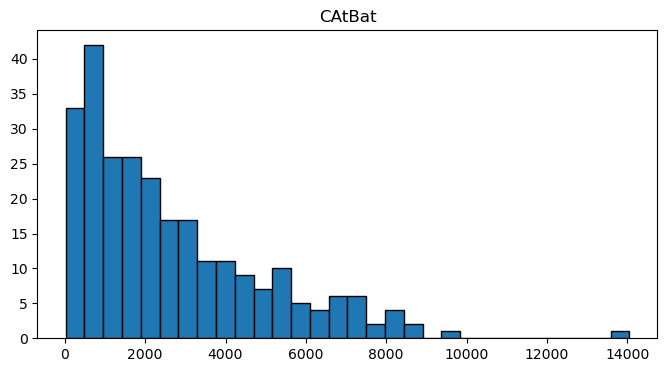

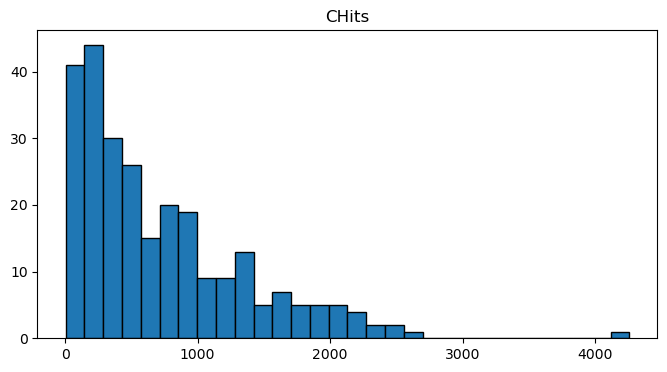

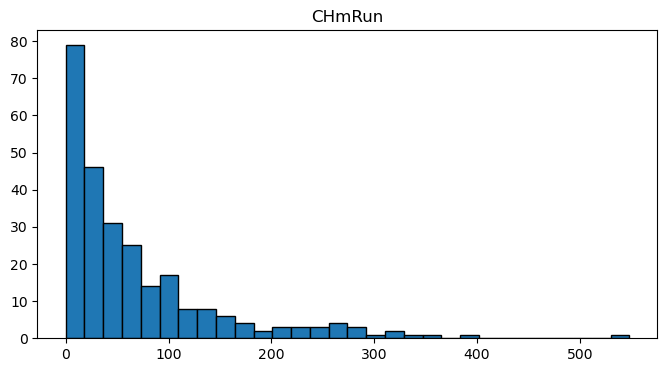

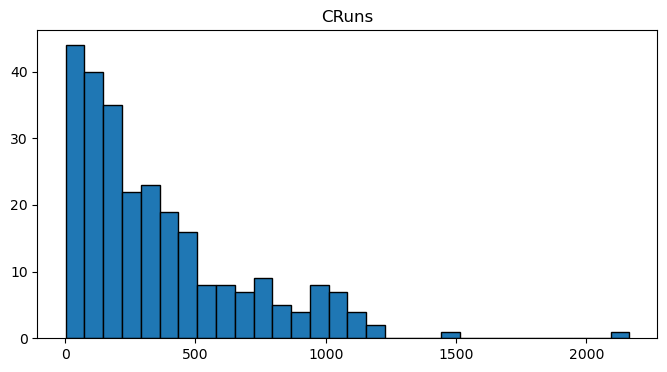

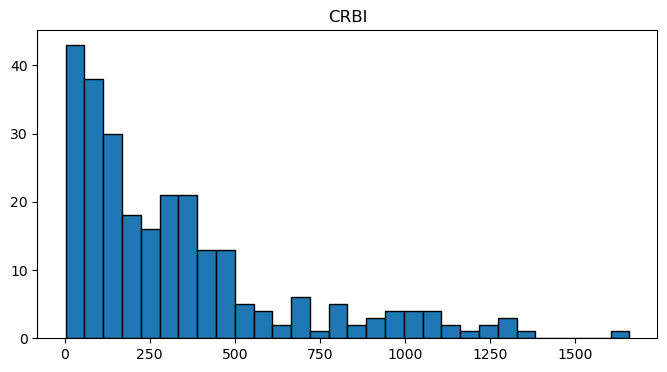

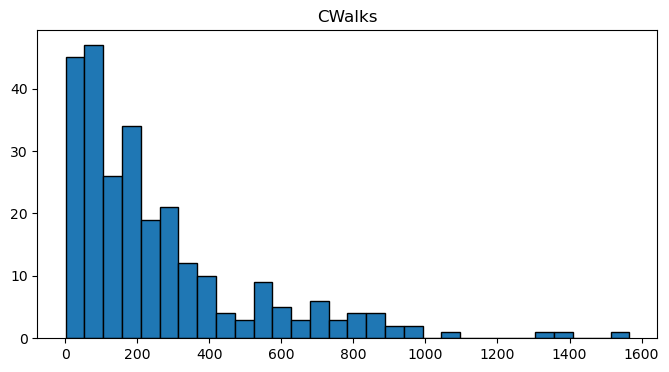

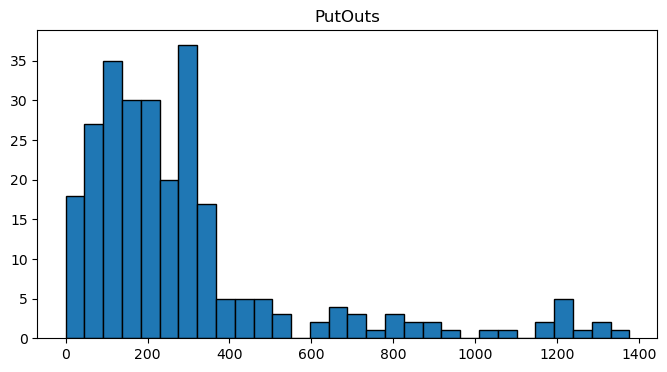

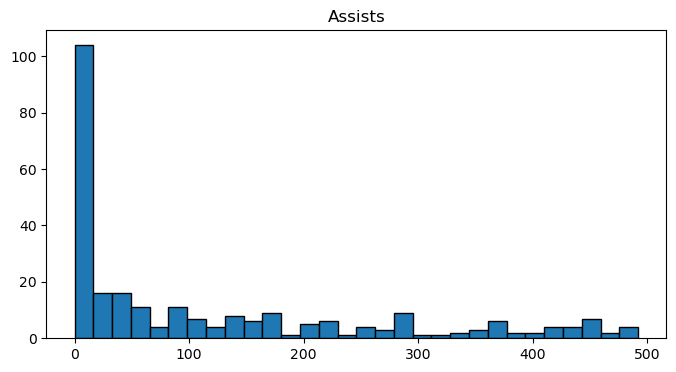

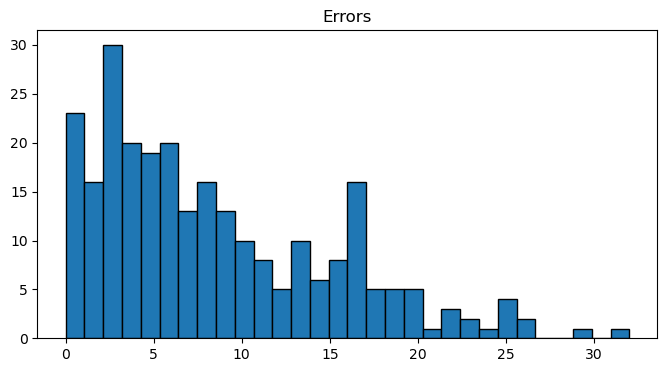

In [22]:
X[numeric_cols].describe()

import matplotlib.pyplot as plt

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(X[col], bins=30, edgecolor='k')
    plt.title(col)
    plt.show()

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [23]:
# the moment of truth!
lasso_mse_scores = -cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
lasso_average_mse = np.mean(lasso_mse_scores)
lasso_average_mse

c:\Users\mehrp\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+04, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(


119076.97656817776

This MSE is slightly lower than your Ridge model (~120,716) and your initial linear regression model (~121,136). Lasso is performing slightly better.

## D Elastic Net

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression



In [24]:
from sklearn.linear_model import ElasticNet

# Setting up the Elastic Net pipeline
elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNet())
])


2. Use cross-validation to tune the 
lambda and alpha hyperparameters.

In [25]:
from sklearn.linear_model import ElasticNetCV

# Range of alpha
alpha_range = np.logspace(-4, 2, 50)  # 0.0001 to 100

# Range of l1_ratio values to try (0 = Ridge, 1 = Lasso)
l1_ratio_range = np.linspace(0.01, 1, 10)  # 0.01 to 1

# ElasticNetCV with ranges for alpha and l1_ratio
elastic_net_cv = ElasticNetCV(alphas=alpha_range, l1_ratio=l1_ratio_range, cv=5, max_iter=10000)

elastic_net_cv.fit(X_transformed, y)
best_alpha, best_l1_ratio = elastic_net_cv.alpha_, elastic_net_cv.l1_ratio_


elastic_net_pipeline.set_params(elastic_net__alpha=best_alpha, elastic_net__l1_ratio=best_l1_ratio)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')),
                                                 ('cat', OneHotEncoder(),
                                                  Index(['League', 'Division', 'NewLeague'], dtype='object'))])),
                ('elastic_net',
                 ElasticNet(alpha=0.015998587196060572, l1_ratio=0.12))])

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

In [26]:
elastic_net_pipeline.fit(X, y)

# the top 5 most influential coefficients
elastic_net_coefficients = pd.Series(elastic_net_pipeline.named_steps['elastic_net'].coef_, 
                                     index=preprocessor.named_transformers_['num'].get_feature_names_out().tolist() + \
                                     preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()) \
                                     .sort_values(key=abs, ascending=False).head(5)
elastic_net_coefficients

Hits      227.031614
AtBat    -212.170328
CRuns     194.803870
CWalks   -142.862782
CHits     119.137279
dtype: float64

For Elastic Net, 'Hits' and 'CRuns' again emerge as strong positive predictors of salary, while 'AtBat' and 'CWalks' negatively impact salary. 'CHits' also positively correlates with salary

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [27]:
# Estimating the MSE for Elastic Net
elastic_net_mse_scores = -cross_val_score(elastic_net_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
elastic_net_average_mse = np.mean(elastic_net_mse_scores)
elastic_net_average_mse

118938.14559498514

The MSE is even better for elastic vs all the other models: Elastic Net: ~118,938

## Part II. Variable Selection

In [96]:
X = hitters_data_clean[['Hits','CRBI','CRuns','AtBat','Years','Division']]

y = hitters_data_clean["Salary"]

### Linear

In [61]:
#LR Only Hits
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")

lr_pipelineHits = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

lr_pipelineHits.fit(X, y)

scores = cross_val_score(lr_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Hits Mean Squared Error: {mean_mse}")

LR Hits Mean Squared Error: 173088.9728644403


In [67]:
#LR Top 5
# Column transformer that standardizes and dummies
ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# pipeline
lr_pipelineTop5 = Pipeline([
    ('preprocessing', ct),
    ('linear_regression', LinearRegression())
])

# Fit pipline
lr_pipelineTop5.fit(X, y)


scores = cross_val_score(lr_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Top 5 Mean Squared Error: {mean_mse}")

LR Top 5 Mean Squared Error: 121965.38677911204


In [68]:
# LR Top 5 + Interaction
# Column transformer that standardizes and dummies
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# pipeline
lr_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('linear_regression', LinearRegression())
])

# Fit pipline
lr_pipelineTop5int.fit(X, y)


scores = cross_val_score(lr_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"LR Top 5 + Interact Mean Squared Error: {mean_mse}")

LR Top 5 + Interact Mean Squared Error: 123078.47016346455


Top5 no interaction performed the best. 

### Ridge 

In [71]:
# Ridge Only Hits Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


ridge_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineHits, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,173046.230311
1,10,172755.975523
2,100,174448.308656


In [72]:
# Ridge Only Hits
# optimal lambda
ridge_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=10))]
)

ridge_pipelineHits.fit(X,y)

scores = cross_val_score(ridge_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Hits Mean Squared Error: {mean_mse}")

Ridge Reg Hits Mean Squared Error: 172755.97552343184


In [73]:
#Ridge Top 5 Tuning
#Only Hits

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")


ridge_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
)

results = [0.1,1,10,100]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineTop5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,0.1,121934.974976
1,1.0,121778.986574
2,10.0,122847.118379
3,100.0,128010.789865


In [74]:
#Ridge Top 5

# optimal lambda
ridge_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge(alpha=1))]
)

ridge_pipelineTop5.fit(X,y)

scores = cross_val_score(ridge_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Top5 Mean Squared Error: {mean_mse}")

Ridge Reg Top5 Mean Squared Error: 121778.98657389611


In [75]:
#Ridge Top 5 + Interaction Tuning

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")

# Creates pipeline
ridge_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge())
])

results = [1,10,100,1000]

lambdas = {'ridge_regression__alpha': results}

gscv = GridSearchCV(ridge_pipelineTop5int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,118417.245434
1,10,115922.255583
2,100,120460.461112
3,1000,147194.772549


In [77]:
#Ridge Top 5 + Interaction


ridge_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge(alpha=10))
])

ridge_pipelineTop5int.fit(X,y)

scores = cross_val_score(ridge_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Ridge Reg Top5 + Int Mean Squared Error: {mean_mse}")

Ridge Reg Top5 + Int Mean Squared Error: 115922.25558303522


### Lasso

In [78]:
# Lasso Only Hits Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


lasso_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

results = [1,10,100]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineHits, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,173076.934306
1,10,173061.634500
2,100,182120.311402


In [79]:
# Lasso Only Hits

# optimal lambda
lasso_pipelineHits = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso(alpha=10))]
)

lasso_pipelineHits.fit(X,y)

scores = cross_val_score(lasso_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Hits Mean Squared Error: {mean_mse}")

Lasso Reg Hits Mean Squared Error: 173061.63450002926


In [80]:
#Lasso Top 5 Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")


lasso_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
)

results = [.0000001,.000001,.00001,.0001]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineTop5, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1.000000e-07,121965.386815
1,1.000000e-06,121965.387148
2,1.000000e-05,121965.388535
3,1.000000e-04,121965.400834


In [81]:
#Lasso Top 5


# optimal lambda
lasso_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Lasso(alpha=.000001))]
)

lasso_pipelineTop5.fit(X,y)

scores = cross_val_score(lasso_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Top5 Mean Squared Error: {mean_mse}")

Lasso Reg Top5 Mean Squared Error: 121965.38714827431


In [82]:
#Lasso Top 5 + Interaction Tuning

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


lasso_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('lasso_regression', Ridge())
])

results = [1,10,100,1000]

lambdas = {'lasso_regression__alpha': results}

gscv = GridSearchCV(lasso_pipelineTop5int, lambdas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)
mse_scores = -gscv_fitted.cv_results_['mean_test_score']
pd.DataFrame(data={"lambdas": results, "MSE scores": mse_scores})

,lambdas,MSE scores
0,1,118417.245434
1,10,115922.255583
2,100,120460.461112
3,1000,147194.772549


In [83]:
#Lasso Top 5 + Interaction

lasso_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ('ridge_regression', Ridge(alpha=10))
])

lasso_pipelineTop5int.fit(X,y)

scores = cross_val_score(lasso_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')
mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Lasso Reg Top5 + Int Mean Squared Error: {mean_mse}")

Lasso Reg Top5 + Int Mean Squared Error: 115922.25558303522


### Elastic

In [84]:
# Elastic Net Only Hits Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits']),
    ], remainder = "drop"
).set_output(transform = "pandas")


# Creating pipeline
enet_pipelineHits = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=100000, tol=0.1))]
)


lambdas = {
    'enet_regression__alpha': np.linspace(0.01, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.01, 1, 10)
}

# GridSearchCV
gscv = GridSearchCV(enet_pipelineHits, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)


results = gscv.cv_results_


df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(3)

,alpha,l1_ratio,mean_squared_error
10,0.12,0.01,172569.569811
24,0.23,0.45,172571.467365
36,0.34,0.67,172578.968935


In [86]:
# Elastic Net Only Hits


enet_pipelineHits = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(alpha=0.33, l1_ratio=0.67, max_iter=100000, tol=0.1))]
)

enet_pipelineHits.fit(X,y)

scores = cross_val_score(lasso_pipelineHits, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Hits Mean Squared Error: {mean_mse}")




Elastic Net Hits Mean Squared Error: 173061.63450002926


In [87]:
#Elastic Net Top 5 Tuning

ct = ColumnTransformer(
    transformers=[
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "drop"
).set_output(transform = "pandas")


enet_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(max_iter=10000, tol=0.1))]
)


lambdas = {
    'enet_regression__alpha': np.linspace(0.1, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.1, 1, 10)
}

# GridSearchCV
gscv = GridSearchCV(enet_pipelineTop5, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)


results = gscv.cv_results_


df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(3)

,alpha,l1_ratio,mean_squared_error
8,0.1,0.9,121810.622067
7,0.1,0.8,122005.489226
99,1.0,1.0,122008.500762


In [88]:
#Elastic Net Top 5 

enet_pipelineTop5 = Pipeline(
  [("preprocessing", ct),
   ("enet_regression", ElasticNet(alpha=0.1, l1_ratio=0.9, max_iter=10000, tol=0.1))]
)

enet_pipelineTop5.fit(X,y)

scores = cross_val_score(enet_pipelineTop5, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Top 5 Mean Squared Error: {mean_mse}")

Elastic Net Top 5 Mean Squared Error: 121810.62206661954


In [89]:
#Elastic Net Top 5 + Interaction Tuning

ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ["Division"]),
        ('Standardize', StandardScaler(), ['Hits','CRBI','CRuns','AtBat','Years']),
    ], remainder = "passthrough"
).set_output(transform = "pandas")

ct_inter = ColumnTransformer(
  [
    ("interaction1", PolynomialFeatures(interaction_only = True), ["Standardize__Hits", "dummify__Division_E"]),
    ("interaction2", PolynomialFeatures(interaction_only = True), ["Standardize__CRBI", "dummify__Division_E"]),
    ("interaction3", PolynomialFeatures(interaction_only = True), ["Standardize__CRuns", "dummify__Division_E"]),
    ("interaction4", PolynomialFeatures(interaction_only = True), ["Standardize__AtBat", "dummify__Division_E"]),
    ("interaction5", PolynomialFeatures(interaction_only = True), ["Standardize__Years", "dummify__Division_E"]),
  ],
  remainder = "drop"
).set_output(transform = "pandas")


enet_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(max_iter=10000, tol=0.1))
])

# parameter grid
lambdas = {
    'enet_regression__alpha': np.linspace(0.1, 1, 10),
    'enet_regression__l1_ratio': np.linspace(0.1, 1, 10)
}

# GridSearchCV
gscv = GridSearchCV(enet_pipelineTop5int, lambdas, cv=5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X,y)


results = gscv.cv_results_


df = pd.DataFrame({
    'alpha': results['param_enet_regression__alpha'],
    'l1_ratio': results['param_enet_regression__l1_ratio'],
    'mean_squared_error': -results['mean_test_score']  # Negating because scores are negative MSE
})

results_df = df.sort_values(by='mean_squared_error')
results_df.head(5)

,alpha,l1_ratio,mean_squared_error
6,0.1,0.7,115789.989629
5,0.1,0.6,115845.199059
17,0.2,0.8,115906.991024
28,0.3,0.9,115951.686624
4,0.1,0.5,115976.519181


In [90]:
#Elastic Net Top 5 + Interaction
# Creates pipeline
enet_pipelineTop5int = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(alpha=0.2,l1_ratio=0.8,max_iter=10000, tol=0.1))
])

enet_pipelineTop5int.fit(X,y)

scores = cross_val_score(enet_pipelineTop5int, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Elastic Net Top 5 + Int Mean Squared Error: {mean_mse}")

Elastic Net Top 5 + Int Mean Squared Error: 115906.9910240294


### Part 2 Intuition: 

Among all the models evaluated in part 2, the Elastic Net, incorporating the top five variables and their interactions, emerged as the superior model, evidenced by its lowest MSE of 115906.99. This superior performance of the Elastic Net model aligns with expectations, given its ability to optimize the blend of Ridge and Lasso regression techniques to minimize MSE. Notably, this MSE is the lowest recorded in our analyses so far.

### Part 3 Discussion:

#### Ridge

The Ridge models outperformed the ordinary regression models in terms of MSE and also exhibited smaller coefficients. This outcome aligns with the characteristics of Ridge regression, a type of penalized regression that imposes constraints on the magnitude of the coefficients (betas), leading to their reduction.

#### Lasso

The ideal lambda values varied across the Lasso regressions depending on the chosen predictors. This variation is logical, considering that the influence and optimal level of lambda would change depending on the specific variables included in each model. Among all the Lasso variants, the model combining the top five variables plus interactions achieved the lowest MSE, recording a value of 115922.26.

#### Elastic Net

In every instance, the Elastic Net models outshone both the Ridge and Lasso models in performance. This outcome is logically consistent, considering that the Elastic Net model is fine-tuned to strike the ideal balance between Ridge and Lasso techniques, aiming to attain the minimum possible MSE for each specific model configuration.

### Part 4, The Final Model:

In [99]:
X = hitters_data_clean.drop(["Salary"],axis=1)
y = hitters_data_clean["Salary"]

#Best Model
# pipeline
best_pipeline = Pipeline([
    ('preprocessing', ct),
   ("interaction", ct_inter),
    ("enet_regression", ElasticNet(alpha=0.2,l1_ratio=0.8,max_iter=10000, tol=0.1))
])

#Fit entire dataset
best_pipeline.fit(X,y)

scores = cross_val_score(best_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')

mse_scores = -scores
mean_mse = mse_scores.mean()

print(f"Best Model Mean Squared Error: {mean_mse}")

Best Model Mean Squared Error: 115906.9910240294


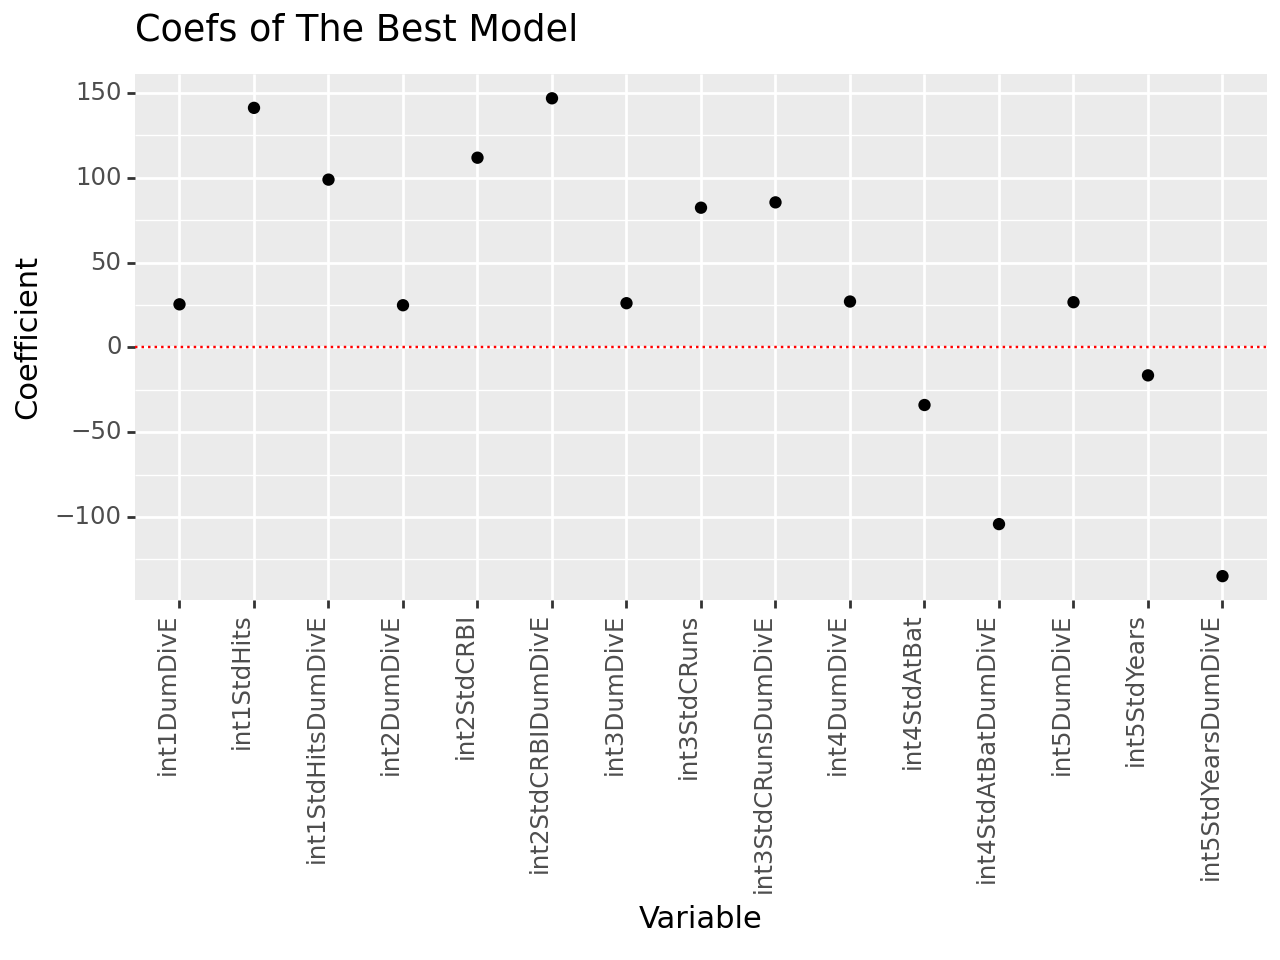

<Figure Size: (640 x 480)>

In [101]:
# Coefficients & var names
coefficients = best_pipeline.named_steps['enet_regression'].coef_

var_names = ct_inter.get_feature_names_out()

# DataFrame
coef_df = pd.DataFrame({
    'Variable': var_names,
    'Coefficient': coefficients
})

# Filter out zero coefficients
coef_df = coef_df[coef_df['Coefficient'] != 0]

import pandas as pd


# Replace 'interaction' with 'int', remove underscores and spaces
coef_df['Variable'] = coef_df['Variable'].str.replace('interaction', 'int', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('Standardize', 'Std', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('dummify', 'Dum', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('Division', 'Div', regex=False)
coef_df['Variable'] = coef_df['Variable'].str.replace('[ _]', '', regex=True)


(ggplot(coef_df, aes(x='Variable', y='Coefficient'))
 + geom_point()
 + geom_hline(yintercept=0, color="red", linetype="dotted")
 + theme(axis_text_x=element_text(angle=90, hjust=1))
 + ggtitle('Coefs of The Best Model'))

The most effective model leveraged the variables we previously pinpointed as having the most substantial coefficients in all model types, namely Hits, CRBI, CRuns, Years, and Division.

Notably, the interaction between CRBI and Division E displayed the highest positive coefficient, while the interaction between AtBat and Division E showed the most significant negative coefficient. This aligns with earlier patterns observed in our models, where CRBI consistently emerged as a key positive influencer, AtBats as a prominent negative influencer, and Division E stood out with the highest impact among the categorical variables from the baseball dataset.